In [206]:
import numpy as np
import pandas as pd 
import os
from sklearn.model_selection import train_test_split
import time
from matplotlib import pyplot as plt
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import NaiveBayesClassifier as nbc
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
import math
nltk.download('stopwords')
from nltk.corpus import stopwords
from operator import itemgetter

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [207]:
import subprocess

command= "cp /kaggle/input/wordnet /kaggle/working/corpora -r"
subprocess.run(command.split())
nltk.data.path.append('/kaggle/working/')

from nltk.corpus import wordnet

In [208]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/chatgpt/chatgpt_text.csv
/kaggle/input/wordnet/wordnet/data.adj
/kaggle/input/wordnet/wordnet/LICENSE
/kaggle/input/wordnet/wordnet/index.adj
/kaggle/input/wordnet/wordnet/README
/kaggle/input/wordnet/wordnet/verb.exc
/kaggle/input/wordnet/wordnet/index.adv
/kaggle/input/wordnet/wordnet/index.verb
/kaggle/input/wordnet/wordnet/data.verb
/kaggle/input/wordnet/wordnet/lexnames
/kaggle/input/wordnet/wordnet/data.noun
/kaggle/input/wordnet/wordnet/noun.exc
/kaggle/input/wordnet/wordnet/index.noun
/kaggle/input/wordnet/wordnet/adj.exc
/kaggle/input/wordnet/wordnet/index.sense
/kaggle/input/wordnet/wordnet/adv.exc
/kaggle/input/wordnet/wordnet/cntlist.rev
/kaggle/input/wordnet/wordnet/data.adv
/kaggle/input/wordnet/wordnet/citation.bib
/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv


In [209]:
train = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_essays.csv")
train.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [210]:
chatgpt_train =  pd.read_csv("/kaggle/input/chatgpt/chatgpt_text.csv")
chatgpt_train.head()

,text,generated
0,In the face of urban challenges like traffic c...,1
1,"In the heart of our bustling urban landscapes,...",1
2,"In our ever-expanding cities, the call to limi...",1
3,"In the bustling heartbeat of our cities, limit...",1
4,"In the ever-evolving urban landscape, the pros...",1


In [211]:
test_dataset = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/test_essays.csv")
test_dataset.head()

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [212]:
train_dataset = pd.concat([train[['text','generated']], chatgpt_train[['text','generated']]])
train_dataset.head()

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0


In [213]:
model_names = []
model_training_times = []
model_accuracy = []

def display_training_time_plot(model_names, model_training_time):
    plt.bar(model_names, model_training_time)
    plt.xlabel('models')
    plt.ylabel('training time')
    plt.xticks(rotation=90)
    plt.title("Training Time of  different models")
    plt.show()
    
def display_accuracy_plot(model_names, accuracy):
    fig, ax = plt.subplots()
    ax.plot(model_names, accuracy)
    plt.xticks(rotation=90)
    ax.legend(['train'])
    plt.show()

In [214]:
#https://www.analyticsvidhya.com/blog/2022/03/building-naive-bayes-classifier-from-scratch-to-perform-sentiment-analysis/

def clean_text(string):
    string = re.sub(r"[^a-zA-Z0-9]+", ' ', string)
    text = ''.join([i for i in string if not i.isdigit()])
    text = re.sub('https://.*','',text)  
    text = text.lower()
    return text

def clean_texts(texts):
    texts = texts.apply(lambda text: clean_text(text))
    return texts


train_dataset['text'] = clean_texts(train_dataset['text'])
test_dataset['text'] = clean_texts(test_dataset['text'])

In [225]:
#https://spotintelligence.com/2022/12/10/stop-words-removal/#:~:text=To%20remove%20stopwords%20with%20Python,your%20own%20list%20of%20stopwords.&text=In%20this%20example%2C%20the%20NLTK,of%20stop%20words%20in%20English.
stop_words = set(stopwords.words('english'))
def remove_stopwords(texts):
    filtered_texts = []
    for text in texts: 
        words = text.split() 
        filtered_words = [word for word in words if word not in stop_words] 
        filtered_texts.append(' '.join(filtered_words))
    return filtered_texts

In [216]:

lemmatizer = WordNetLemmatizer()
def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    wordnet_tagged = map(lambda x: (x[0], nltk_pos_tagger(x[1])), nltk_tagged)
    lemmatized_sentence = []
    
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)


porter_stemmer  = PorterStemmer()
def stem_sentence(sentence):
    tokenized = nltk.word_tokenize(sentence) 
    stemmed_sentence = []
    for word in tokenized:
            stemmed_sentence.append(porter_stemmer.stem(word))
    return " ".join(stemmed_sentence)

In [217]:
def build_vocab(texts):
    vocabulary = {}
    for text in texts:
        tokenized = nltk.word_tokenize(text)
        for word in tokenized:
            if tokenized.count(word)>5 and not vocabulary.__contains__(word):
                vocabulary[word] = tokenized.count(word)
    return vocabulary

def find_prob(texts,word):
    success = 0
    for text in texts:
        list_of_words = text.split(' ')
        if list_of_words.count(word)>1:
            success = success + 1
    return success/len(texts)


In [218]:
def build_prob_dict(X_train,y_train):
    probability_dict = {}
    combined_training_dataset = pd.DataFrame()
    combined_training_dataset['text'] = X_train.copy()
    combined_training_dataset['generated'] = y_train.copy()
    llm_training_dataset = combined_training_dataset[combined_training_dataset['generated'] == 1]
    human_training_dataset = combined_training_dataset[combined_training_dataset['generated'] == 0]
    vocab = build_vocab(combined_training_dataset['text'])

    word_prob_llm = {}
    word_prob_human = {}
    for key,value in vocab.items():
        probability_dict[key] = find_prob(combined_training_dataset['text'],key)

        llm_prob = find_prob(llm_training_dataset['text'],key)
        word_prob_llm[key] = llm_prob
        probability_dict[key+'__LLM'] = llm_prob

        human_prob = find_prob(human_training_dataset['text'],key)
        word_prob_human[key] = human_prob
        probability_dict[key+'__human'] = human_prob

    llm_texts_count = len(combined_training_dataset[combined_training_dataset['generated']==1])
    human_texts_count = combined_training_dataset.shape[0] - llm_texts_count
    llm_prob = llm_texts_count/combined_training_dataset.shape[0]
    
    return probability_dict, vocab, word_prob_llm, word_prob_human, llm_texts_count, human_texts_count, llm_prob

In [219]:
def get_top_ten(word_prob_dict):
    res = dict(sorted(word_prob_dict.items(), key=itemgetter(1), reverse=True)[:10])
    return res.keys()

In [220]:
def predict(essay,vocab,probability_dict,llm_texts_count,human_texts_count,llm_prob ):
    missing_token_count = 0
    tokenized = nltk.word_tokenize(essay)
    
    new_tokenized_list = []
    for token in tokenized:
        if tokenized.count(token) > 5 and token not in new_tokenized_list:
            new_tokenized_list.append(token)
    
    for token in new_tokenized_list:
        if not vocab.__contains__(token):
            missing_token_count = missing_token_count + 1
        if not vocab.__contains__(token):
            missing_token_count = missing_token_count + 1
    
    llm_prob_num = 0
    human_prob_num = 0
    for token in new_tokenized_list:
        if not vocab.__contains__(token):
            llm_prob_num = llm_prob_num + math.log10((1)/(llm_texts_count + missing_token_count))
        else:
            llm_prob_num = llm_prob_num + math.log10((probability_dict[token+'__LLM']*llm_texts_count +1)/(llm_texts_count + missing_token_count))
        if not vocab.__contains__(token):
            human_prob_num = human_prob_num + math.log10((1)/(human_texts_count + missing_token_count))
        else:
            human_prob_num = human_prob_num + math.log10((probability_dict[token+'__human']*human_texts_count +1)/(human_texts_count + missing_token_count))
        
    llm_prob_num = llm_prob_num + math.log10(llm_prob)
    human_prob_num = human_prob_num  + math.log10(1 - llm_prob)
    
    total_llm_prob = np.divide(10**llm_prob_num,np.add((10**llm_prob_num),(10**human_prob_num)))
    
    return total_llm_prob


Naive Bayes using lemmatization preprocessing technique.

In [221]:
start_time = time.time()

lemma_train_dataset = train_dataset.copy()
lemma_train_dataset['text'] = list(map(lambda text: lemmatize_sentence(text), lemma_train_dataset['text']))
X_train, X_test, y_train, y_test = train_test_split(lemma_train_dataset['text'], lemma_train_dataset['generated'], test_size=0.2, random_state=42)
probability_dict, vocab, word_prob_llm, word_prob_human, llm_texts_count, human_texts_count, llm_prob = build_prob_dict(X_train,y_train)
print('top 10 words for LLM classification', get_top_ten(word_prob_llm))
print('top 10 words for human classification', get_top_ten(word_prob_human))

predicted_categories = []
for essay in X_test:
    predicted_categories.append( 1 if predict(essay, vocab, probability_dict, llm_texts_count,human_texts_count,llm_prob)> 0.5 else 0)
    
end_time = time.time()
    
print(metrics.classification_report(y_test, predicted_categories))
print('Development accuracy: ',metrics.accuracy_score(y_test, predicted_categories))

model_names.append('NB_lemma')
model_training_times.append(end_time-start_time)
model_accuracy.append(metrics.accuracy_score(y_test, predicted_categories))

top 10 words for LLM classification dict_keys(['the', 'a', 'of', 'to', 'be', 'in', 'electoral', 'college', 'and', 'our'])
top 10 words for human classification dict_keys(['the', 'be', 'of', 'in', 'a', 'and', 'to', 'have', 'that', 'for'])
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       275
           1       0.00      0.00      0.00         3

    accuracy                           0.98       278
   macro avg       0.49      0.49      0.49       278
weighted avg       0.98      0.98      0.98       278

Development accuracy:  0.9784172661870504


Naive Bayes using stemming preprocessing

In [222]:
start_time = time.time()

stem_train_dataset = train_dataset.copy()
stem_train_dataset['text'] = list(map(lambda text: stem_sentence(text), stem_train_dataset['text']))
X_train, X_test, y_train, y_test = train_test_split(stem_train_dataset['text'], stem_train_dataset['generated'], test_size=0.2, random_state=42)
probability_dict, vocab, word_prob_llm, word_prob_human, llm_texts_count, human_texts_count, llm_prob = build_prob_dict(X_train,y_train)

print('Top 10 words for LLM classification', get_top_ten(word_prob_llm))
print('Top 10 words for human classification', get_top_ten(word_prob_human))

predicted_categories = []
for essay in X_test:
    predicted_categories.append( 1 if predict(essay, vocab, probability_dict, llm_texts_count,human_texts_count,llm_prob)> 0.5 else 0)
    
end_time = time.time()

print(metrics.classification_report(y_test, predicted_categories))
print('Development accuracy: ',metrics.accuracy_score(y_test, predicted_categories))

model_names.append('NB_stem')
model_training_times.append(end_time-start_time)
model_accuracy.append(metrics.accuracy_score(y_test, predicted_categories))

Top 10 words for LLM classification dict_keys(['the', 'a', 'of', 'to', 'in', 'elector', 'colleg', 'is', 'and', 'our'])
Top 10 words for human classification dict_keys(['the', 'of', 'in', 'a', 'and', 'to', 'is', 'that', 'it', 'for'])
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       275
           1       0.00      0.00      0.00         3

    accuracy                           0.98       278
   macro avg       0.49      0.50      0.50       278
weighted avg       0.98      0.98      0.98       278

Development accuracy:  0.9820143884892086


In [226]:
train_dataset['text'] = remove_stopwords(train_dataset['text'])
test_dataset['text'] = remove_stopwords(test_dataset['text'])
train_dataset.head()

,text,generated
0,cars cars around since became famous henry for...,0
1,transportation large necessity countries world...,0
2,america love affair vehicles seems cooling say...,0
3,often ride car drive one motor vehicle work st...,0
4,cars wonderful thing perhaps one worlds greate...,0


In [227]:
start_time = time.time()

lemma_train_dataset = train_dataset.copy()
lemma_train_dataset['text'] = list(map(lambda text: lemmatize_sentence(text), lemma_train_dataset['text']))
X_train, X_test, y_train, y_test = train_test_split(lemma_train_dataset['text'], lemma_train_dataset['generated'], test_size=0.2, random_state=42)
probability_dict, vocab, word_prob_llm, word_prob_human, llm_texts_count, human_texts_count, llm_prob = build_prob_dict(X_train,y_train)
print('top 10 words for LLM classification', get_top_ten(word_prob_llm))
print('top 10 words for human classification', get_top_ten(word_prob_human))

predicted_categories = []
for essay in X_test:
    predicted_categories.append( 1 if predict(essay, vocab, probability_dict, llm_texts_count,human_texts_count,llm_prob)> 0.5 else 0)
    
end_time = time.time()
    
print(metrics.classification_report(y_test, predicted_categories))
print('Development accuracy: ',metrics.accuracy_score(y_test, predicted_categories))

model_names.append('NB_lemma_no_stopword')
model_training_times.append(end_time-start_time)
model_accuracy.append(metrics.accuracy_score(y_test, predicted_categories))

top 10 words for LLM classification dict_keys(['electoral', 'college', 'vote', 'system', 'candidate', 'process', 'popular', 'citizen', 'car', 'city'])
top 10 words for human classification dict_keys(['people', 'state', 'would', 'car', 'get', 'one', 'vote', 'electoral', 'college', 'go'])
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       275
           1       0.20      0.67      0.31         3

    accuracy                           0.97       278
   macro avg       0.60      0.82      0.65       278
weighted avg       0.99      0.97      0.98       278

Development accuracy:  0.9676258992805755


In [228]:
start_time = time.time()

stem_train_dataset = train_dataset.copy()
stem_train_dataset['text'] = list(map(lambda text: stem_sentence(text), stem_train_dataset['text']))
X_train, X_test, y_train, y_test = train_test_split(stem_train_dataset['text'], stem_train_dataset['generated'], test_size=0.2, random_state=42)
probability_dict, vocab, word_prob_llm, word_prob_human, llm_texts_count, human_texts_count, llm_prob = build_prob_dict(X_train,y_train)

print('Top 10 words for LLM classification', get_top_ten(word_prob_llm))
print('Top 10 words for human classification', get_top_ten(word_prob_human))

predicted_categories = []
for essay in X_test:
    predicted_categories.append( 1 if predict(essay, vocab, probability_dict, llm_texts_count,human_texts_count,llm_prob)> 0.5 else 0)
    
end_time = time.time()

print(metrics.classification_report(y_test, predicted_categories))
print('Development accuracy: ',metrics.accuracy_score(y_test, predicted_categories))

model_names.append('NB_stem_no_stopword')
model_training_times.append(end_time-start_time)
model_accuracy.append(metrics.accuracy_score(y_test, predicted_categories))

Top 10 words for LLM classification dict_keys(['elector', 'colleg', 'vote', 'system', 'candid', 'process', 'citizen', 'presid', 'popular', 'popul'])
Top 10 words for human classification dict_keys(['peopl', 'state', 'would', 'car', 'one', 'elector', 'vote', 'get', 'colleg', 'mani'])
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       275
           1       0.17      0.67      0.27         3

    accuracy                           0.96       278
   macro avg       0.58      0.82      0.62       278
weighted avg       0.99      0.96      0.97       278

Development accuracy:  0.960431654676259


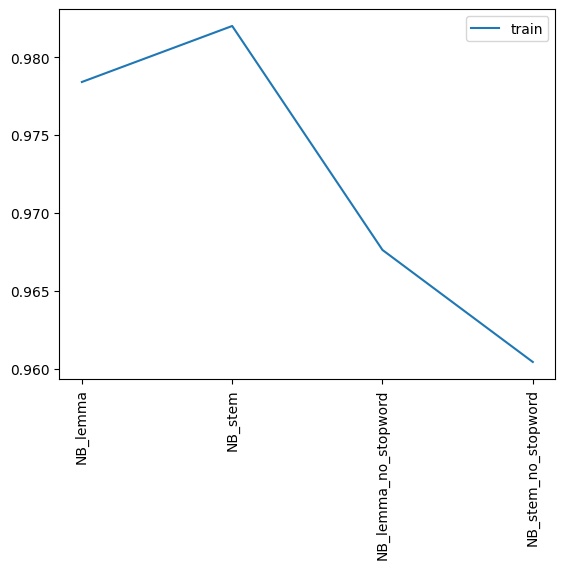

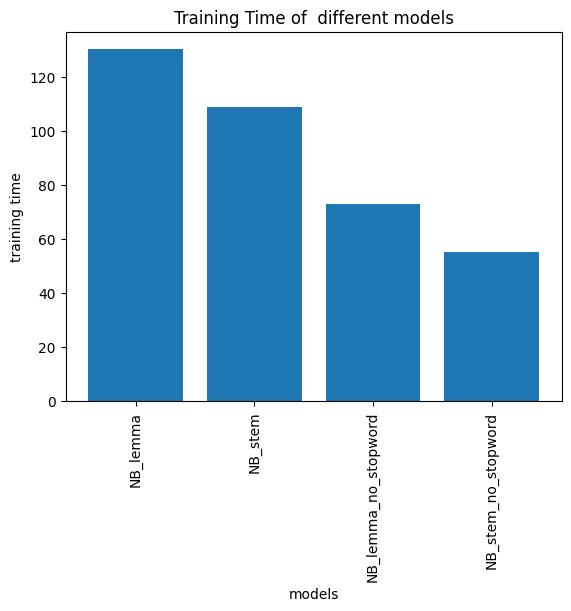

In [229]:
display_accuracy_plot(model_names, model_accuracy)
print()
display_training_time_plot(model_names, model_training_times)

In [230]:
predicted_categories = []
for essay in test_dataset['text']:
    predicted_categories.append(predict(essay, vocab, probability_dict, llm_texts_count,human_texts_count,llm_prob))
output = pd.DataFrame({'id': test_dataset['id'], 'generated': predicted_categories})
output.to_csv('submission.csv', index=False)